In [105]:
import pandas as pd
from numpy import NaN
from numpy.polynomial.polynomial import polyfit
from sklearn import linear_model, metrics, model_selection
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix

#read in csv with stats
df_stats = pd.read_csv('data/Pitching.csv')
#Older entries don't have IBB, SH, SF, GIDP, so fills these stats in as 0 if not present
df_stats[['IBB', 'SH', 'SF', 'GIDP']] = df_stats[['IBB', 'SH', 'SF', 'GIDP']].fillna(0)
#function that finds the ERA that a pitcher pitched the year after the year of the row given, fills with NaN if does not exist
def find_next_year_era(row, df):
    to_return = df.loc[(df['playerID'] == row['playerID']) & (df['yearID'] == row['yearID'] + 1)]
    if to_return.empty:
        print(to_return)
        return NaN
    else:
        new_value = to_return.ERA
        return new_value.iloc[0]

#create dataframe from 1993 onward to train stats on, older data is more inconsistent
recent_data = df_stats[df_stats.yearID.between(1993, 2022)]
#Train data on starters who will have more consistent numbers
recent_data = recent_data[recent_data.GS > 10]
#Add ERA from next season pitched, if it exists
recent_data['newERA'] = recent_data.apply(find_next_year_era, axis=1, args=(recent_data,))
#remove any seasons that don't have a future season to train off of
recent_data = recent_data.dropna()
#remove irrelevant info like name and team
x = recent_data.drop(recent_data.columns[0:5], axis=1)
#remove new ERA that will be used to evaluate
x = x.drop(recent_data.columns[30], axis=1)
print(x)
y = recent_data[recent_data.columns[30]]
#split into training and testing data
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3)
#Create and train linear regression
linear_regression_model = linear_model.LinearRegression()
linear_regression_model.fit(x_train, y_train)
linear_regression_model_pred = linear_regression_model.predict(x_test)

ridge_regression_model = linear_model.Ridge()
ridge_regression_model.fit(x_train, y_train)
ridge_regression_model_pred = ridge_regression_model.predict(x_test)

print('linear r-squared: ', metrics.r2_score(y_test, linear_regression_model_pred))
print('linear MSE: ', metrics.mean_squared_error(y_test, linear_regression_model_pred))
print('ridge r-squared: ', metrics.r2_score(y_test, ridge_regression_model_pred))
print('ridge MSE: ', metrics.mean_squared_error(y_test, ridge_regression_model_pred))
print('ERA season prior: ', metrics.r2_score(recent_data.newERA, recent_data.ERA))

C:\Users\Iris Gant\AppData\Local\Temp\ipykernel_28576\1717752154.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  return to_return.ER.sum() / to_return.IPouts.sum() * 27


Empty DataFrame
Columns: [playerID, yearID, stint, teamID, lgID, W, L, G, GS, CG, SHO, SV, IPouts, H, ER, HR, BB, SO, BAOpp, ERA, IBB, WP, HBP, BK, BFP, GF, R, SH, SF, GIDP, careerERA]
Index: []

[0 rows x 31 columns]
Empty DataFrame
Columns: [playerID, yearID, stint, teamID, lgID, W, L, G, GS, CG, SHO, SV, IPouts, H, ER, HR, BB, SO, BAOpp, ERA, IBB, WP, HBP, BK, BFP, GF, R, SH, SF, GIDP, careerERA]
Index: []

[0 rows x 31 columns]
Empty DataFrame
Columns: [playerID, yearID, stint, teamID, lgID, W, L, G, GS, CG, SHO, SV, IPouts, H, ER, HR, BB, SO, BAOpp, ERA, IBB, WP, HBP, BK, BFP, GF, R, SH, SF, GIDP, careerERA]
Index: []

[0 rows x 31 columns]
Empty DataFrame
Columns: [playerID, yearID, stint, teamID, lgID, W, L, G, GS, CG, SHO, SV, IPouts, H, ER, HR, BB, SO, BAOpp, ERA, IBB, WP, HBP, BK, BFP, GF, R, SH, SF, GIDP, careerERA]
Index: []

[0 rows x 31 columns]
Empty DataFrame
Columns: [playerID, yearID, stint, teamID, lgID, W, L, G, GS, CG, SHO, SV, IPouts, H, ER, HR, BB, SO, BAOpp, ERA

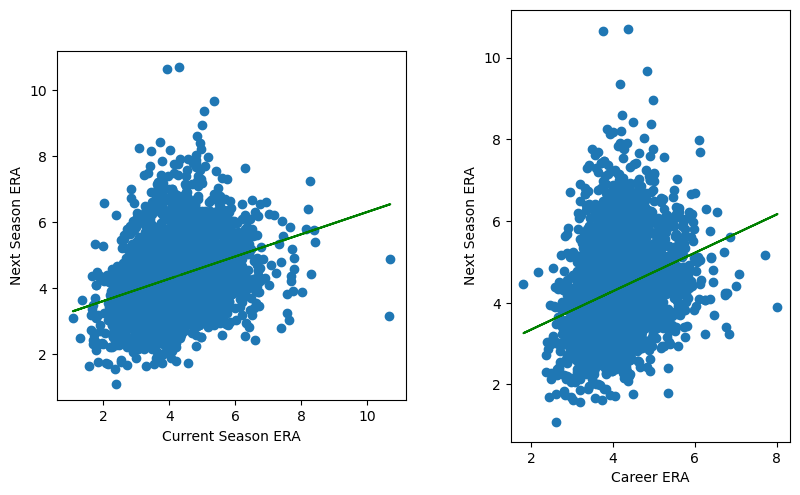

In [107]:
def find_career_era(row, df):
    to_return = df.loc[(df['playerID'] == row['playerID']) & (df['yearID'] <= row['yearID'])]
    if 0 in to_return.ER.values:
        return NaN
    else:
        return to_return.ER.sum() / to_return.IPouts.sum() * 27
career_stats = recent_data.copy()
career_stats['careerERA'] = career_stats.apply(find_career_era, axis=1, args=(df_stats,))

fig, ax = plt.subplots(1, 2)
ax[0].set_aspect('equal')

ax[0].scatter(recent_data.ERA, recent_data.newERA)
b0, m0 = polyfit(recent_data.ERA, recent_data.newERA, 1)
ax[0].plot(recent_data.ERA, b0 + m0 * recent_data.ERA, 'g')
ax[0].set(xlabel='Current Season ERA', ylabel='Next Season ERA')
ax[1].scatter(recent_data.careerERA, recent_data.newERA)
b1, m1 = polyfit(recent_data.careerERA, recent_data.newERA, 1)
ax[1].plot(recent_data.careerERA, b1 + m1 * recent_data.careerERA, 'g')
ax[1].set(xlabel='Career ERA', ylabel='Next Season ERA')
ax[1].set_aspect(1, adjustable='box')
plt.subplots_adjust(left=0.05, right=1.25, bottom=0.05, top=0.95)
plt.show()

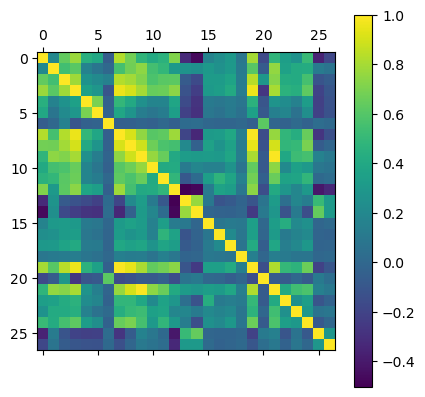

In [108]:
fig = plt.matshow(recent_data.drop(recent_data.columns[0:5], axis=1).corr())
plt.colorbar(fig)
plt.show()

In [109]:
recent_data.drop(recent_data.columns[0:5], axis=1).corr().style.background_gradient(cmap='coolwarm')

,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,careerERA,newERA
W,1.000000,0.196842,0.640490,0.774269,0.446956,0.395185,-0.060805,0.826750,0.678425,0.477992,0.410162,0.464296,0.713470,-0.325595,-0.462879,0.167692,0.237231,0.298226,0.089686,0.797514,-0.173698,0.480814,0.337950,0.265392,0.516400,-0.352614,-0.184740
L,0.196842,1.000000,0.542158,0.617634,0.165368,0.078858,0.002772,0.557874,0.672744,0.747347,0.551408,0.493328,0.303072,0.266641,0.244787,0.306310,0.254856,0.304697,0.116239,0.607738,-0.069239,0.758591,0.358747,0.415745,0.419971,0.122165,0.074911
G,0.640490,0.542158,1.000000,0.788212,0.261486,0.213402,0.154289,0.827705,0.794132,0.717519,0.576857,0.616308,0.622236,-0.073354,-0.165393,0.322759,0.321487,0.366589,0.130400,0.840996,0.293629,0.724898,0.419150,0.415654,0.559208,-0.111720,-0.065257
GS,0.774269,0.617634,0.788212,1.000000,0.349705,0.284086,-0.108302,0.955469,0.903394,0.796375,0.650840,0.661418,0.740968,-0.116872,-0.227356,0.311407,0.335905,0.410387,0.133251,0.963110,-0.267450,0.801918,0.462518,0.437556,0.625770,-0.199143,-0.099917
CG,0.446956,0.165368,0.261486,0.349705,1.000000,0.699251,-0.037661,0.491595,0.403702,0.252580,0.173773,0.174678,0.377979,-0.162541,-0.275766,0.111472,0.092943,0.119379,0.083374,0.462514,-0.108031,0.268120,0.229727,0.158419,0.328046,-0.217812,-0.117892
SHO,0.395185,0.078858,0.213402,0.284086,0.699251,1.000000,-0.025398,0.385656,0.274812,0.134725,0.087244,0.130625,0.338206,-0.214526,-0.291028,0.094061,0.063883,0.109912,0.054585,0.353005,-0.085552,0.143738,0.182597,0.063810,0.238751,-0.212834,-0.127698
SV,-0.060805,0.002772,0.154289,-0.108302,-0.037661,-0.025398,1.000000,-0.050193,-0.041686,-0.020009,-0.034570,0.006010,-0.042720,0.019243,0.036449,-0.001241,-0.010755,-0.015301,0.007255,-0.044988,0.618411,-0.015854,-0.032386,0.014676,-0.028857,0.031857,0.009360
IPouts,0.826750,0.557874,0.827705,0.955469,0.491595,0.385656,-0.050193,1.000000,0.911229,0.749886,0.610608,0.625026,0.777767,-0.189375,-0.338924,0.317365,0.324670,0.394790,0.143235,0.992642,-0.152697,0.759683,0.484559,0.433422,0.653004,-0.269212,-0.137599
H,0.678425,0.672744,0.794132,0.903394,0.403702,0.274812,-0.041686,0.911229,1.000000,0.893846,0.667499,0.572839,0.548614,0.202981,-0.039647,0.354582,0.271564,0.353868,0.129049,0.942317,-0.122364,0.902784,0.484325,0.503282,0.696657,-0.064468,-0.004620
ER,0.477992,0.747347,0.717519,0.796375,0.252580,0.134725,-0.020009,0.749886,0.893846,1.000000,0.762048,0.651330,0.405762,0.325512,0.315302,0.321242,0.309922,0.378206,0.132248,0.811285,-0.075833,0.989329,0.392655,0.527442,0.559102,0.165883,0.102314


In [106]:
#read in csv with names
df_names = pd.read_csv('data/People.csv')
print('To predict Future ERA, please enter the following: ')
while True:
    try:
        #get inputs of first name, last name, and year pitched
        first_name = input('Please enter the pitcher\'s first name: ')
        last_name = input('Please enter the pitcher\'s last name: ')
        year = int(input('Please enter the year to predict: ')) - 1
        #get player ID from first and last name
        player_id = df_names.loc[(df_names.nameFirst == first_name) & (df_names.nameLast == last_name)].playerID.values[0]
        individual_predict = linear_regression_model.predict(df_stats.loc[(df_stats.playerID == player_id) & (df_stats.yearID == year)].drop(df_stats.columns[0:5], axis=1))
        print('The predicted ERA is:', individual_predict[0])
    except ValueError as e:
        print(e)
        print('Please enter a valid number for the year.')
    except:
        print('The name entered does not appear to be in the database for the year entered. Please try again.')
    restart = input('Try again? (y/n): ')
    if restart.lower() == 'n':
        break

To predict Future ERA, please enter the following: 
The predicted ERA is: 3.4721020750177827
